# Project: Final Paper

#### CS8321: Neural Networks and Machine Learning
    
Will Lacey - 45906124

## Project Description
<em>My description ya ya ya</em>

## Import Modules and Initialization

Before we begin, let's import essential packages for data analysis.

In [1]:
from __future__ import division

import multiprocessing.pool
import sys
import os
import tensorflow as tf
import keras.backend as K
import h5py
import numpy as np
import imageio
import matplotlib.pyplot as plt
import torch.nn as nn
import scipy.misc
import scipy.sparse
import scipy.sparse.linalg

from PIL import Image
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input, UpSampling2D
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
from numpy.lib.stride_tricks import as_strided
from functools import partial

import warnings
warnings.simplefilter('ignore')

print(tf.__version__)

Using TensorFlow backend.


2.1.0


### Building the VGG Encoder

In [2]:
def vgg_layers(inputs, target_layer):
    """
    Loads the layers of the VGG network
    """
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x


def load_weights(model):
    """
    Loads the VGG weights from Chollet's github. Sets the following weights to the convolutional layers. 
    """
    
    link_p1 = 'https://github.com/fchollet/deep-learning-models/releases/'
    link_p2 = 'download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    
    weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            (link_p1+link_p2),
                            cache_subdir='models',
                            file_hash='253f8cb515780f3b799900260a226db6')
    f = h5py.File(weights_path)
    
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.);
        Prepares the VGG model
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    """
    Preprocesses input for the model; Most notably this function transfers the RGB of an image to BGR
    """
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - np.array([103.939, 116.779, 123.68])

### Building the Decoder

In [3]:
def decoder_layers(inputs, layer):
    """
    Gets a set of decoder layers for a decoder model; this structure will for the most part mirror 
        VGG's implementation
    """
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

### Constructing the Model

In [4]:
def l2_loss(x):
    """
    Helper loss function using L2 normalization
    """
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256, 256, 3), target_layer=5,
                 decoder_path=None, loss_lambda=1):
        """
        Initialization function for the EncoderDecoder Object
        """
        self.input_shape = input_shape
        self.target_layer = target_layer
        self.loss_lambda = loss_lambda

        # Builds the model from the encoder and decoder functions seen above
        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path, compile=False) # load pre-trained weights for decoder
        else:
            self.decoder = self.create_decoder(target_layer) # ...or build weights froms scratch

        # models are sequentially constructed
        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)

        self.loss = self.create_loss_fn(self.encoder)

        # using adam optimizer and our defined loss
        optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, beta_1=0.4, beta_2=0.999)
        self.model.compile(optimizer=optimizer, loss=self.loss)

    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            """
            Gets the VGG encodings 
            """
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            """
            Defined loss function for training
            """
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   self.loss_lambda*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        """
        Creates the decoder submodel from the decoder functions above
        """
        inputs = Input(shape=self.encoder.output_shape[1:])
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, output, name='decoder_%s' % target_layer)

    def export_decoder(self):
        """
        Exports the decoder weights/model
        """
        self.decoder.save('data/models/decoder_%s.h5' % self.target_layer)

### Defining some Utility Functions

In [5]:
def count_number_of_images(path):
    """
    Counts the number of files within a directory; the structure of the directory must be 
        dataset -> class directories -> class images
    """
    white_list_file_types = ['png', 'jpg', 'jpeg', 'bmp', 'ppm']
    num_samples = 0
    
    path, directories, files = next(os.walk(path))
    for directory in directories:
        path_of_dir = path + '/' + directory
        p, ds, fs = next(os.walk(path_of_dir))
        for f in fs:
            for file_type in white_list_file_types: 
                if file_type in f:
                    num_samples += 1
    return num_samples

def format_image(img, is_clipping=False): 
    """
    Formats an image by either clipping values below or above 0 and 255 or alternatively 
        normalizes the least and the greatest values relative to 0 and 255; float image is 
        returned as a uint8
    """
    if is_clipping:
        img = np.clip(img / 255, 0, 1)
        
    else:
        if np.amin(img) < 0:
            adjust = - np.amin(img)
            img = img + adjust
        if np.amax(img) > 255:
            img = img.astype(np.float64) / np.amax(img) 
        else:
            img = img.astype(np.float64) / 255
        
    img = 255 * img # Now scale by 255
    return img.astype(np.uint8)

### Prepare Training

In [6]:
def create_gen(img_dir, target_size, batch_size):
    """
    Generates data from an image directory
    """
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)
    def tuple_gen():
        for img in gen:
            if img.shape[0] != batch_size:
                continue

            # (X, y)
            yield (img, img)

    return tuple_gen()

class OutputPreview(Callback):

    def __init__(self, model, test_img_path, preview_dir_path, image_size=(256, 256), increment=5000):
        test_img = image.load_img(test_img_path)
        """
        Initialization function for Output Preview Object; Declares class variables
        """
        test_img = test_img.resize(image_size) # Assumes using 3 channels
    
        test_target = image.img_to_array(test_img)
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model

        self.preview_dir_path = preview_dir_path

        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        """
        Defines what to do during training at the end of a batch; outputs current progress of image reconstruction
        """
        if (self.iteration % self.increment == 0):
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            
            # normalize and convert image then save image to show preview of output
            output_img = format_image(output_img)
            imageio.imwrite(out_path, output_img)

        self.iteration += 1

Awesome. Everything is ready for creating our model and training. Now we're going to quickly create some variables to train.

In [12]:
# Parameters
train_path = 'data/datasets/faces'
image_size = (64, 64)
batch_size = 64
epochs = 5000

target_layer = 4 # ranges from values 1 through 5
loss_lambda = 1 # ranges from values 0 through 1

is_using_callbacks = True
callbacks_image_path = "data/input/nick_cage.png"
callbacks_preview_path = "data/output"

### Execute Training

In [13]:
# Generates data
gen = create_gen(train_path, image_size, batch_size)

# steps per epoch are determined by the number of samples and batch size
num_samples = count_number_of_images(train_path)
steps_per_epoch = num_samples // batch_size

# define our encoder_decoder model
encoder_decoder = EncoderDecoder(input_shape=(image_size[0], image_size[1], 3), 
                                 target_layer=target_layer, 
                                 loss_lambda=loss_lambda)

# wether or not to use callbacks and preview decoded output during training
if (is_using_callbacks):
    callbacks = [OutputPreview(encoder_decoder, callbacks_image_path, 
                               callbacks_preview_path, image_size=image_size)]
    encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,
                                        epochs=epochs, callbacks=callbacks)
else:
    encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=epochs)

# export trained output
encoder_decoder.export_decoder()

Found 340 images belonging to 1 classes.
Epoch 1/5000


KeyboardInterrupt: 

### Plotting Function

In [9]:
def plot_decoded_image_gallery(input_image_path, output_image_dir):
    """
    Plotting image gallery for decoded output from a encoder/decoder model; Plots an original image next to five 
    reconstructions from different model layers
    """
    plt.figure(figsize=(16, 10))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    plt.subplot(2, 3, 1)
    img = image.load_img(input_image_path)
    plt.imshow(img)
    plt.title('original', size=12)
    plt.xticks(())
    plt.yticks(())
    
    for index in range(5):
        plt.subplot(2, 3, index + 2)
        path = output_image_dir + 'decoder' + str(index+1) + '_output.png'
        img = image.load_img(path)
        
        plt.imshow(img)
        plt.title('decoder ' + str(index+1), size=12)
#         plt.xticks(())
#         plt.yticks(())

### Training Evaluation

In [10]:
# Parameters
input_image_path = "data/input/nick_cage.png"
output_images_dir = 'data/output/'

# Preprocessing
input_img = image.load_img(input_image_path)
input_img = input_img.resize(image_size)
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)

Okay...

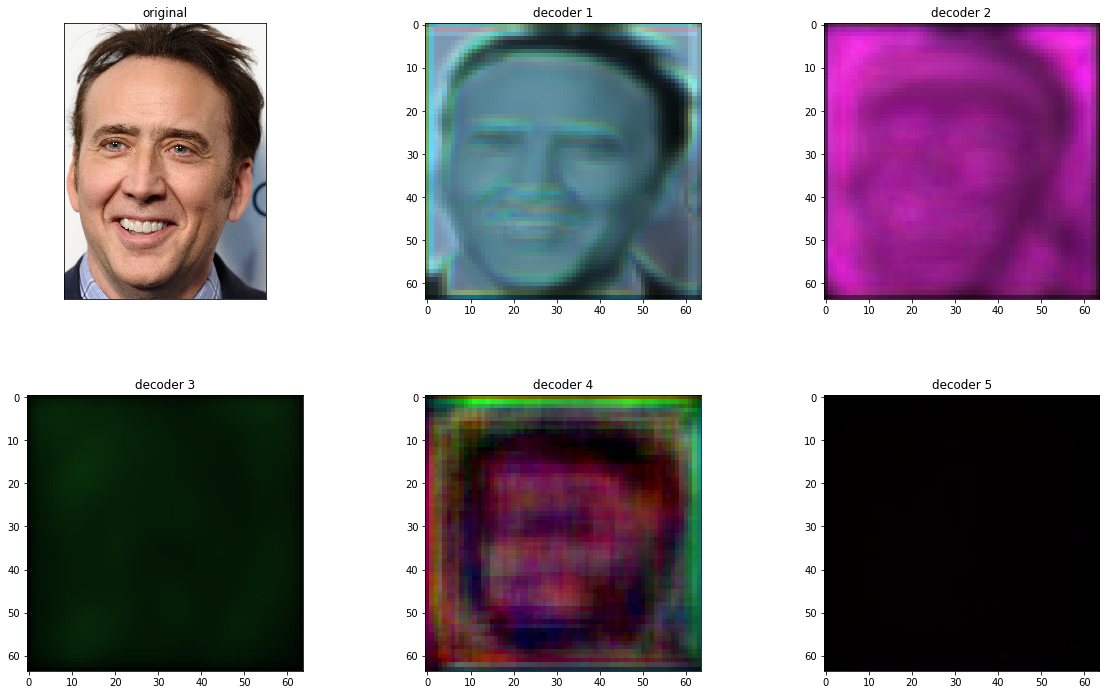

In [11]:
# Evaluation
for target_layer in range(1, 6):   
    # Loads weights for decoder
    decoder_path = 'data/models/decoder_' + str(target_layer) + '.h5'
    
    # Builds model through a specified weights path and target layer
    encoder_decoder = EncoderDecoder(input_shape=(image_size[0], image_size[1], 3),
                                     decoder_path=decoder_path, 
                                     target_layer=target_layer)

    # gets decoded output
    output_img = encoder_decoder.model.predict([input_img])[0]

    # Convert image to uint8 then saves output
    output_img = format_image(output_img)
    output_image_path = output_images_dir + 'decoder' + str(target_layer) + '_output.png'
    imageio.imwrite(output_image_path, output_img)
    
plot_decoded_image_gallery(input_image_path, output_images_dir)